In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, FeatureUnion

In [10]:
#train = pd.read_csv("Data/train.csv")
#test = pd.read_csv("Data/test.csv")
train = pd.read_csv("~/Desktop/Learning Python/HandsOnML/Titanic/train.csv")
test = pd.read_csv("~/Desktop/Learning Python/HandsOnML/Titanic/test.csv")

Text(0.5,1,'Fare paid (sorted values)')

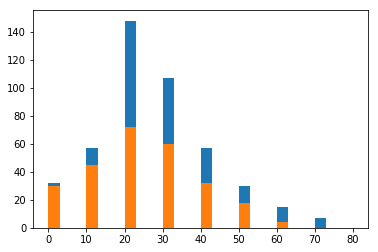

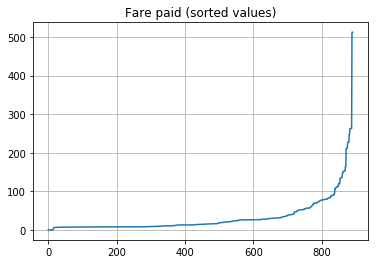

In [11]:
"""Playing with data"""
aM = train[train["Sex"]=="male"]
aM = aM["Age"].dropna()
aF = train[train["Sex"]=="female"]
aF = aF["Age"].dropna()
plt.hist(aM, bins=8, width=3, range=[0, 80])
plt.hist(aF, bins=8, width=3, range=[0, 80], align="mid")
#print(min(ageDist), max(ageDist))

plt.figure()
plt.plot(train["Fare"].sort_values().values)
plt.grid()
plt.title("Fare paid (sorted values)")

In [12]:
"""Data Clean up"""
""" Assumptions:
- Name is irrelevant to survival but title could be
- Ticket ID is irrelevant too
- Cabin number could be relevant if mapped to distance to boats/exits but info not provided so irrelvant
- Port in which they embarked is likely to be irrelevant. Could be useful if nationality was at play but in the disaster likely not to be

Data engineering:
"""


X_train = train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
X_test = test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
# Encode Sex into 0 or 1
encoder = LabelEncoder()
X_train["Sex"]=encoder.fit_transform(X_train["Sex"])
X_test["Sex"]=encoder.fit_transform(X_test["Sex"])

#print(X_train["Sex"].value_counts()) # indicate which is male, which is female

/home/alexandre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alexandre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/alexandre/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Repartition per traveler class')

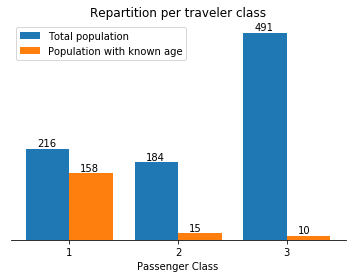

In [19]:
# Problem: we have some unknown age values
# To be relevant, we need to populate them or remove them.
plt.figure()
df = train.dropna()
n, bins, _ = plt.hist([train["Pclass"], df["Pclass"]], bins=3, align = "left", width=0.4, range=(1, 4), label=["Total population", "Population with known age"])
plt.xticks(np.arange(1, 4))
plt.legend()
# Add values on top of hist
for i, v in enumerate(train["Pclass"].value_counts().sort_index()):
    plt.text(i+1-0.3, v+5, v)
for i, v in enumerate(df["Pclass"].value_counts().sort_index()):
    plt.text(i+1+0.1, v+5, v)
plt.tick_params(axis="y", left="off", right="off", labelleft="off", labelcolor="red", gridOn=False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Passenger Class")
plt.title("Repartition per traveler class")

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
    
# STEP 1: define a pipeline
numColumns=["Pclass", "Age", "SibSp", "Parch", "Fare"]
catColumns=["Sex"]
numPipeline = Pipeline([
                      ('columnSelector', DataFrameSelector(numColumns)),
                      ('imputer', Imputer(strategy="median")),
                      ('scaler', StandardScaler())
                      ])
catPipeline = Pipeline([
                      ('columnSelector', DataFrameSelector(catColumns)),
                      ('labelBinarizer', MyLabelBinarizer())
                      ])
fullPipeline = FeatureUnion([('num', numPipeline), ('cat', catPipeline)])
Y_train = train["Survived"]

train_prepro = fullPipeline.fit_transform(train)
test_prepro = fullPipeline.fit_transform(test)

In [74]:
test_prepro.sum()

266.00000000000011

In [39]:
sgd = SGDClassifier()
sgd_scores = cross_val_score(sgd, train_prepro, Y_train, cv=10, n_jobs=-1, verbose=0)

/home/alexandre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/alexandre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/alex

0.76556350017024177

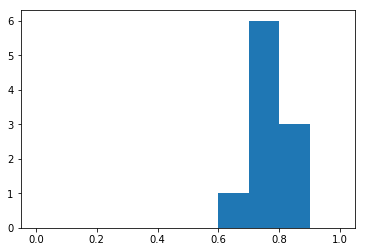

In [40]:
plt.figure()
plt.hist(sgd_scores, bins=10, range=(0, 1))
sgd_scores.mean()

In [76]:
# Conclusion of this round: not great
# Let's try the other models (KNN, Random Forest)
# Then we will do a grid search

from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
knn_scores = cross_val_score(knn, train_prepro, Y_train, cv=100, n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  

[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.81813888888888897

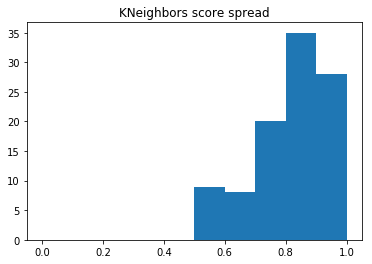

In [77]:
plt.figure()
plt.hist(knn_scores, bins=10, range=(0, 1))
plt.title("KNeighbors score spread")
knn_scores.mean()

In [82]:
knn.fit(train_prepro, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [84]:
result = knn.predict(test_prepro)

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0,

In [87]:
resultToCsv = pd.DataFrame()
resultToCsv["PassengerId"] = np.arange(892, 1310)
resultToCsv["Survived"] = result
resultToCsv.to_csv("submission2.csv")

In [45]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr_scores = cross_val_score(rfr, train_prepro, Y_train, cv=100, n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  

[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


0.25336269743284917

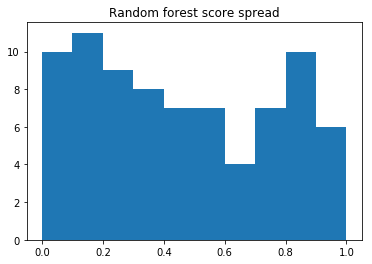

In [46]:
plt.figure()
plt.hist(rfr_scores, bins=10, range=(0, 1))
plt.title("Random forest score spread")
rfr_scores.mean()

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {"leaf_size": [30], \
              "n_neighbors":np.arange(2, 40, 2), \
              "algorithm":["auto"], \
              "metric": ["minkowski"], \
              "p": [2], \
              "weights": ["uniform"]}
gridSearch = GridSearchCV(knn, param_grid=param_grid, verbose=2, pre_dispatch=2, cv=100)

In [58]:
gridSearch.fit(train_prepro, Y_train)

Fitting 100 folds for each of 19 candidates, totalling 1900 fits
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=2, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=4, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=6, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=8, p=2, weights=uniform 
[CV]  algorithm=auto, lea

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=uniform 
[CV]  algorithm

[Parallel(n_jobs=1)]: Done 1900 out of 1900 | elapsed:   26.5s finished


GridSearchCV(cv=100, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'leaf_size': [30], 'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38]), 'algorithm': ['auto'], 'metric': ['minkowski'], 'p': [2], 'weights': ['uniform']},
       pre_dispatch=2, refit=True, return_train_score='warn', scoring=None,
       verbose=2)

In [59]:
cvrs=gridSearch.cv_results_
print(cvrs["mean_test_score"].max(), 
     cvrs["mean_test_score"].mean())
print(cvrs["params"][cvrs["mean_test_score"].argmax()])

0.81593714927 0.796916533759
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}


In [315]:
X_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,29.599282,0.447368,0.392344,35.576535
std,0.841838,0.481622,12.703770,0.896760,0.981429,55.850103
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800
50%,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200


In [318]:
final_model = gridSearch.best_estimator_

In [320]:
result = final_model.predict(X_test)

In [322]:
# Create the final DataFrame to export
df = pd.DataFrame()
df["PassengerId"] = np.arange(892, 1310, 1)
df["Survived"] = result

In [326]:
# You need to delete the index column afterward
df.to_csv("Data/submission.csv")